In [1]:
"""
#### Code adapted from the source code of ArtEmis dataset paper
"""

import json
import torch
import pandas as pd
import os.path as osp
import numpy as np
import itertools
from PIL import Image
from model.func_eval import unpickle_data,torch_load_model
from artemis.utils.vocabulary import Vocabulary #Use for text2emotion metrics
from artemis.evaluation.single_caption_per_image import apply_basic_evaluations
from artemis.emotions import IDX_TO_EMOTION
%load_ext autoreload
%autoreload 2

In [2]:
DBdir = "../Dataset/ArtEmis/ArtEmis"
modelname = 'CLIPViTB16_full' #'CLIPViTB16_full','CLIPViTB16_woSG','INRN34_full','INRN34_woSG','INViTB16_full','INViTB16_woSG'

model_dir = f'output/Ours_ArtEmis/{modelname}'
sampled_captions_file = osp.join(model_dir,'fullDB_test.pkl')

In [3]:
references_file = osp.join(DBdir,'Artemis_GT.pkl')
split = 'test'
gpu_id = 0

# the evaluation of the longest-common-subsequence is quite slow -- so we sub-sampled the data:
default_lcs_sample = [25000, 800]
# First integer (25000) = number of training (gt) sentences to subsample from all training
# Secong integer (800)  = number of sample sentences to subsample from all generations

In [4]:
device = "cpu"
evaluation_methods = {'bleu', 'meteor', 'rouge', 'spice','cider'}
print(evaluation_methods) 

{'cider', 'rouge', 'bleu', 'spice', 'meteor'}


In [5]:
from model.count_IdC import count_IdC

In [6]:
print("Evaluating on ArtEmis...")
gt_data = next(unpickle_data(references_file))
train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

saved_samples = next(unpickle_data(sampled_captions_file))
for sampling_config_details, captions in saved_samples:  # you might have sampled under several sampling configurations
    merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
    merged['caption'] = merged.captions_predicted
    hypothesis = merged.caption
    references = merged.references_pre_vocab # i.e., use references that do not have <UNK>

    metrics_eval = apply_basic_evaluations(hypothesis, references, None, None, None, 
                                           nltk_bleu=False, lcs_sample=default_lcs_sample,
                                           train_utterances=unique_train_utters,
                                           methods_to_do=evaluation_methods)
    print("Using combined types!")
    print(pd.DataFrame(metrics_eval))
    merged_IdC,merged_LC_df = count_IdC(merged)
    print("Number of Id-Captions:",len(merged_IdC))
    print("Number of unique Id-Captions:",len(set(merged_IdC.caption.tolist())))
    print("Number of literal Captions:",len(merged_LC_df))
    print("Number of unique literal Captions:",len(set(merged_LC_df.caption.tolist())))
    print()
    
    

Evaluating on ArtEmis...
Training Utterances 348197
Images Captioned 5497
BLEU: done
COCO-based-metrics: done
Using combined types!
   metric      mean       std
0  BLEU-0  0.594824  0.191176
1  BLEU-1  0.362577  0.228319
2  BLEU-2  0.212816  0.203863
3  BLEU-3  0.126417  0.142550
4   CIDER  0.101720  0.131304
5   SPICE  0.060951  0.051080
6  METEOR  0.154998  0.062765
7   ROUGE  0.323750  0.110567
Number of Id-Captions: 4102
Number of unique Id-Captions: 2910
Number of literal Captions: 1395
Number of unique literal Captions: 1132



In [7]:
print("Evaluating on ArtEmis literal captions ...")
references_file = osp.join(DBdir,'Artemis_GT_LC.pkl')
gt_data = next(unpickle_data(references_file))
train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
merged['caption'] = merged.LC_predicted
hypothesis = merged.caption
references = merged.references_pre_vocab # i.e., use references that do not have <UNK>

metrics_eval = apply_basic_evaluations(hypothesis, references, None, None, None, 
                                       nltk_bleu=False, lcs_sample=default_lcs_sample,
                                       train_utterances=unique_train_utters,
                                       methods_to_do=evaluation_methods)
print(pd.DataFrame(metrics_eval))
merged_IdC,merged_LC_df = count_IdC(merged)
print("Number of Id-Captions:",len(merged_IdC))
print("Number of unique Id-Captions:",len(set(merged_IdC.caption.tolist())))
print("Number of literal Captions:",len(merged_LC_df))
print("Number of unique literal Captions:",len(set(merged_LC_df.caption.tolist())))
print()




Evaluating on ArtEmis literal captions ...
Training Utterances 272688
Images Captioned 4019
BLEU: done
COCO-based-metrics: done
   metric      mean       std
0  BLEU-0  0.608941  0.182750
1  BLEU-1  0.367473  0.216461
2  BLEU-2  0.202563  0.184938
3  BLEU-3  0.102783  0.104729
4   CIDER  0.125132  0.152900
5   SPICE  0.072659  0.056319
6  METEOR  0.152841  0.061955
7   ROUGE  0.333413  0.102603
Number of Id-Captions: 9
Number of unique Id-Captions: 9
Number of literal Captions: 4010
Number of unique literal Captions: 3309



Evaluating on ArtEmis literal captions ...
1


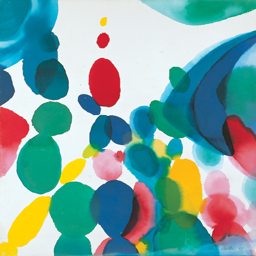

Generated caption: the colors are bright and the bright colors remind me of a child 
Generated LC: the colors are bright and the shapes are very playful 
Generated IdC: the colors are bright and the bright colors remind me of a child 
Ground-truth captions: ['this image appears delightful and its geometrics appear aesthetically soothing', 'the colors and shapes are happy', 'the colors and pattern are relaxing for me', 'the colors are very soothing', 'it is a really playful color scheme and very light almost watercolor', 'the bright color palette combined with the fun shapes make this painting lively it makes me smile'] 

101


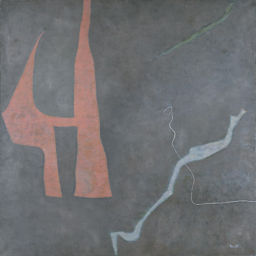

Generated caption: the shapes look like a skull of a child 
Generated LC: the painting is very simple and the colors are very relating 
Generated IdC: the shapes look like a skull of a child 
Ground-truth captions: ['the strange shapes and domination of blackness is depressing and makes me feel sad', 'really no feelings when looking at this painting', 'not being sure of my feelings on this painting but it could be an abstract over sketch of a <unk> area', 'the dark and muted town of this image makes me sad', 'i feel sad when i look at the shapes in this image', 'confused about what this is but the gray background and subdued colors gives a somber feeling'] 

201


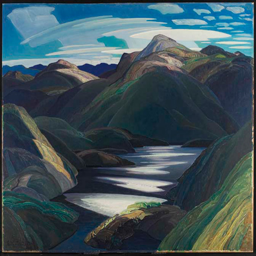

Generated caption: the mountains look like they are in the water 
Generated LC: the colors are very calming and the water is a nice contrast to the mountains 
Generated IdC: the mountains look like they are in the water 
Ground-truth captions: ['i am a little bored by this one maybe it is because all the colors are so dark but i do feel cool looking at it it certainly captures the feeling of shadows', 'the beautiful landscape as well as the surrealism of all the colors', '<unk> to <unk> clouds in the <unk> and water reflections in the moonlight love how the greens are bright and warm', 'the shapes of the clouds and mountains are so abstract i find it really interesting and different from other landscapes i have seen it feels more fantastical', 'the scenery of the mountains and the river look very calm and peaceful'] 

401


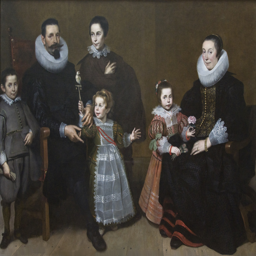

Generated caption: the faces look like they are having a good 
Generated LC: the people are very happy and the children are all seem very realistic 
Generated IdC: the faces look like they are having a good 
Ground-truth captions: ['i feel content looking at the beautiful family in this photo and the lovely children that came from such attractive parents', "the colors used are bland but the saving grace is the playfulness in the children 's faces", 'it is a beautiful and lifelike family portrait but <unk> they are all long dead now', 'seeing what i expected father and son with the same face mother and daughters all have the same face just some <unk> for age', 'this family portrait of nobles dressed in their finest <unk> to offset the drab colors of their clothing is an ostentatious display of wealth when one considers the cost of <unk> such a painting'] 

901


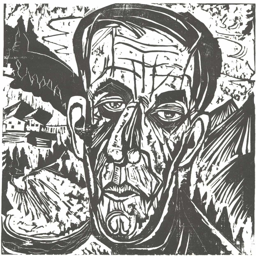

Generated caption: the man looks like he is very sad since he has since his face 
Generated LC: the man 's face is very sad and the dark colors are dark 
Generated IdC: the man looks like he is very sad since he has since his face 
Ground-truth captions: ['this is pretty neat and has a lot goin on kind of exciting lookin around and seeing more and more', 'strange looking piece but i like all the lines and black and white paints', '<unk> stretched out and elongated face makes me feel out of place and wary', "the use of one color to create a person 's portrait forest town river and hill", 'even though the long face depicted is <unk> human the long streaks the nose that appears disfigured the explosive nature of the surrounding lines and swirls even the town which feels deserted are all hauntingly disquieting', 'this fellow just looks very cynical and unfriendly i also find that the painting has a very chaotic theme to it that comes across as agitating', 'i like the elongated perspective 

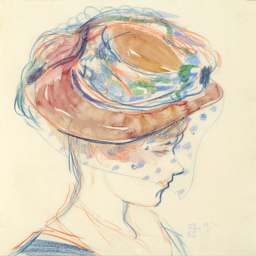

Generated caption: the woman 's hat looks like a clown 
Generated LC: the woman 's eyelashes are very pretty and she looks very elegant 
Generated IdC: the woman 's hat looks like a clown 
Ground-truth captions: ['the bizarre coloring of the hat really makes me laugh there is something funny about it', 'very nice calm painting lovely details', 'a well dressed lady from an earlier age she seems content with her life', 'the hat is so ethereal with the splash of water colors', 'the brush strokes are loose the color benign the subject relaxed'] 

1301


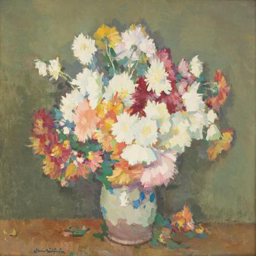

Generated caption: the flowers look like they are picked been to die 
Generated LC: the flowers are so pretty and the vase is a nice contrast to the white flowers 
Generated IdC: the flowers look like they are picked been to die 
Ground-truth captions: ['this makes me feel relaxed with the soft colors of the flowers it is a relatable picture as well a scene that you may see at your own house', 'the attention to detail in the flowers in addition to the general softness of the painting', 'many different awesome colors of flowers', 'there are vibrant and calm colors of flowers against a warm green background', 'flowers that are peaceful and calm background'] 

1401


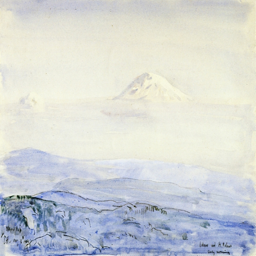

Generated caption: the snow looks like it is been coated a blanket mountain 
Generated LC: the snow covered mountain in the distance is very calming 
Generated IdC: the snow looks like it is been coated a blanket mountain 
Ground-truth captions: ['two thirds of the canvas is awash with white light and a snow covered mountain with no sign of life', 'the vast empty snowy fields look desolate and dreary', 'this picture seems very empty and cold somewhere i would never want to visit', 'the mountain coming out of the clouds looks so peaceful and amazing', 'a great painting of a snow covered set of hills i looks inviting to anyone who loves to play in the snowy hills', 'the cool blue colors and the light snow mountain are calming'] 

1601


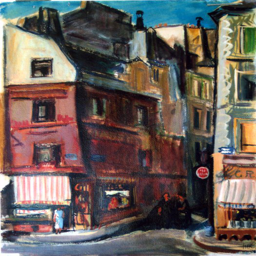

Generated caption: the colors are so bright and the picture looks like a nice place to visit 
Generated LC: the colors are very dark and the buildings are a little bit scary 
Generated IdC: the colors are so bright and the picture looks like a nice place to visit 
Ground-truth captions: ['this is the sort of street i would like to explore when i was <unk> in germany the mixture of old and modern buildings is always interesting', 'the body language used here for the people makes me worry they are not doing well', 'the blocky shapes are amusing and i like the way the buildings blend into one another', 'simple day with a dark red <unk> and few people in the streets making it look tired', 'this town seems gloomy since there is only one person standing outside on the sidewalk', 'the black cloaked red faced creatures are lurking around the corner ready to attack', 'i do not know what i would not give to be there i want to know what is down the alley', 'the bright colors in the buildings and 

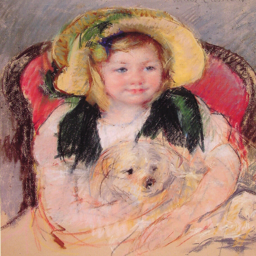

Generated caption: the child 's face is very cute and adorable 
Generated LC: the child 's face is very cute and adorable 
Generated IdC: the girl looks like she is happy since her since she has a cute face 
Ground-truth captions: ['there is a lot of energy in the strokes of paint on the dog it looks very lively', 'the young girl has a very charming smile', 'what could get better than a child and her puppy the face is really drawn well too', 'nice to see this little girl enjoying herself with the dog they look happy', "the girl 's expression looks so self satisfied and comfortable with an <unk> that seems above her years and complete control of the relatively less detailed puppy she holds", 'the hat on the young man in the red chair with his dog shows contentment i like the scribble style', "this painting makes me feel happy i like the pleasant smile on the girl 's face and the dog although a bit abstract is obvious also the yellow hat with fruit is a bit old fashioned but looks approp

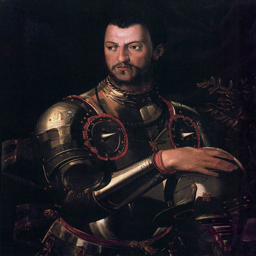

Generated caption: the man looks like he is about to kill his armor since he has a battle 
Generated LC: the man 's face is very detailed and the colors are very dark 
Generated IdC: the man looks like he is about to kill his armor since he has a battle 
Ground-truth captions: ['regret the face of ma thinking about past', 'something about the expression in his face makes me feel sad for him', 'a nice picture of an handsome man', "the darkness of the painting and the man 's facial expression are threatening", 'the man looks important and <unk>'] 

2701


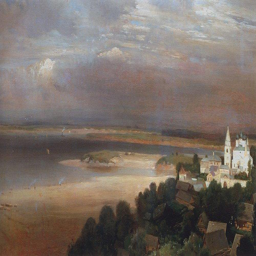

Generated caption: the clouds look like they are been since a nice place 
Generated LC: the sky is very dark and the water is a nice contrast to the lake 
Generated IdC: the clouds look like they are been since a nice place 
Ground-truth captions: ['the horizon meets the ocean', 'viewing a small city on the edge of the sea is very relaxing', 'the landscape painting is calm but the colors make me feel sadness or loneliness', 'the scene is beautiful and depicts an idyllic setting', 'gloomy skies and foreboding shadows hand over the village by the sea'] 

2801


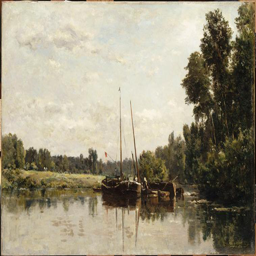

Generated caption: the clouds look like they are sailing 
Generated LC: the water is calm and the boats are calm 
Generated IdC: the clouds look like they are sailing 
Ground-truth captions: ['there is a calmness to the water that makes me think the ships journey would be peaceful', 'a peaceful day for a boat ride with fluffy white clouds and still water', 'the calm water makes me feel calm and i like when an artist does water reflection well like this', 'the natural scene of the water trees and sky and a boat resting in the harbor looks pleasant', 'the boats and the reflections on the water are calming and serene'] 

3601


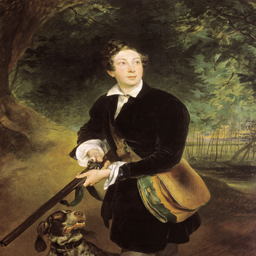

Generated caption: the man looks like he is wearing a victorian instrument 
Generated LC: the man is wearing a very fancy clothing and a tree 
Generated IdC: the man looks like he is wearing a victorian instrument 
Ground-truth captions: ['i do not like guns even though the man probably hunting since he is being accompanied with a dog', 'the woman is protected by her <unk> and loyal dog', 'a man with a <unk> holds a rifle by his dog', 'the use of light and dark to create a visible texture on the velvet jacket is amazing the flesh tones on the hands and face seem an <unk> so realistic', 'the man with a gun and his dog is awesome', 'the young boy is from the upper <unk> of society and yet he is experiencing using a gun and hunting with his <unk> hunting dog by his side', 'the man is out on a <unk> with his dog both of them loving each other', 'the young man and his dog look to the distance in excitement for what is to come ahead the facial expression and look of the dog shows adventure',

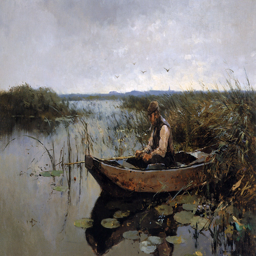

Generated caption: the man is rowing the biggest fishing in the boat 
Generated LC: the man is rowing the biggest fishing in the boat 
Generated IdC: the man looks like he is very hard since he enjoys to his fishing 
Ground-truth captions: ['the fisherman looks sad like he has not caught anything in a while', 'this is a man in a rowboat just before or after a storm diagonal grass indicates wind', 'the calm still water suggests a very serene day', 'the man looks to be pondering his life on the peaceful lake', 'a man sits alone in a boat on the bay among the lily pads'] 

3301


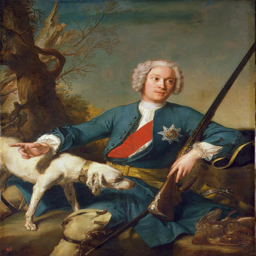

Generated caption: the man looks like he is having he looks very awkward 
Generated LC: the man is very happy and the dog is resting on the side of the dogs 
Generated IdC: the man looks like he is having he looks very awkward 
Ground-truth captions: ['the sky has taken on the colors in his jacket contentment', 'the dog in the painting is very cute and i like that it is curious about the gun', 'he is just come from <unk> his lover in the <unk> and the dog does not mind', 'i like the dogs in this painting and how cute they are', 'the dog is not causing trouble'] 

3001


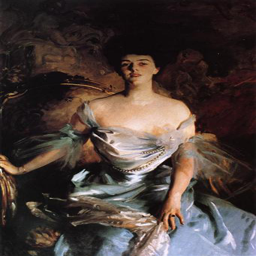

Generated caption: the woman 's dress is very attractive and beautiful 
Generated LC: the woman 's dress is very attractive and beautiful 
Generated IdC: the woman looks like she is having a very happy since a good time 
Ground-truth captions: ['the blues in the dress stand out against the brown chair and background but her waist looks a little odd really drawing my eye there versus the rest of the painting', 'she shows off a mature beauty with her dress and blue gown', 'the shadows and light play on her like she is in a big haunted mansion her dress is fancy but the background is just dreary and looks old and musty', 'women who is very well aware of her beauty <unk> and about to undress', 'the dress is so detailed and the lace accents give the woman a stately appearance', 'sexy alluring dark calling nice', 'a woman wearing a fluffy dress that is very ornate is getting ready to go out for the night', 'a painting of a woman from a era long gone posing with a beautiful elaborate dress le

In [8]:
print("Evaluating on ArtEmis literal captions ...")
img_dir = '../Dataset/ArtEmis/OriginalArtEmis/wikiart/'
for random_id in [1,101,201,401,901,1201,1301,1401,1601,1701,1901,2701,2801,3601,1501,3301,3001]:
    print(random_id)
    row = merged.iloc[random_id]
    img_file = osp.join(img_dir, row['art_style'], row['painting'] + '.jpg')
    image = Image.open(img_file).resize((256, 256))
    display(image)
    print("Generated caption:",row['captions_predicted'],
          "\nGenerated LC:",row['LC_predicted'],
          "\nGenerated IdC:",row['IdC_predicted'],
          "\nGround-truth captions:",row['references'],"\n") 

In [9]:
print("Evaluating on ArtEmis Id-captions ...")
references_file = osp.join(DBdir,'Artemis_GT_IdC.pkl')
gt_data = next(unpickle_data(references_file))
train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
merged['caption'] = merged.IdC_predicted
hypothesis = merged.caption
references = merged.references_pre_vocab # i.e., use references that do not have <UNK>
metrics_eval = apply_basic_evaluations(hypothesis, references, None, None, None, 
                                           nltk_bleu=False, lcs_sample=default_lcs_sample,
                                           train_utterances=unique_train_utters,
                                           methods_to_do=evaluation_methods)
print("Using only IdC!")
print(pd.DataFrame(metrics_eval))
merged_IdC,merged_LC_df = count_IdC(merged)
print("Number of Id-Captions:",len(merged_IdC))
print("Number of unique Id-Captions:",len(set(merged_IdC.caption.tolist())))
print("Number of literal Captions:",len(merged_LC_df))
print("Number of unique literal Captions:",len(set(merged_LC_df.caption.tolist())))
print()

Evaluating on ArtEmis Id-captions ...
Training Utterances 75509
Images Captioned 2497
BLEU: done
COCO-based-metrics: done
Using only IdC!
   metric      mean       std
0  BLEU-0  0.608645  0.164519
1  BLEU-1  0.412664  0.179834
2  BLEU-2  0.274635  0.208775
3  BLEU-3  0.188817  0.176441
4   CIDER  0.114375  0.160756
5   SPICE  0.064212  0.055627
6  METEOR  0.189755  0.061222
7   ROUGE  0.365952  0.110102
Number of Id-Captions: 2489
Number of unique Id-Captions: 2000
Number of literal Captions: 8
Number of unique literal Captions: 6



Evaluating on ArtEmis Id-captions ...


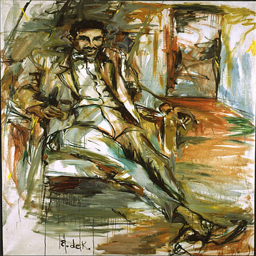

Generated caption: the man looks very relaxed and the colors are very ominous 
Generated LC: the man looks very relaxed and the colors are very ominous 
Generated IdC: the man looks like he is in a drug since he has a lot of his face 
Ground-truth captions: ["the harsh lines and expression of the man 's face makes me feel like he is up to something very bad", 'even though the painting itself seems a bit chaotic the guy looks like he is just relaxing', "this makes me feel like there is a lot of chaos in this particular man 's situation i would not want to be in this state of mind", 'he looks like a dashing gentleman who is waiting for a lady to charm', 'the man seems to be mean'] 



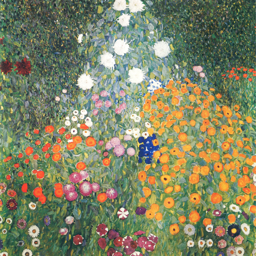

Generated caption: the flowers look like they are being poured to the yellow 
Generated LC: the flowers are so pretty and the colors are very pretty 
Generated IdC: the flowers look like they are being poured to the yellow 
Ground-truth captions: ['this serene field of flowers has many bright and vivid colors that flow so well together and makes you feel as though you are in another world', 'the bright colors on the flowers look like a happy spring day', 'i am not liking the lack of talent here i do not like the lack of detail that was put into the flowers the measurements seem to be too off', 'this feels like a warm sunny day in a garden surrounded by the gentle perfume of flowers', 'it is a field of flowers with a nice range of color with nobody around this seems like it would be a nice area to relax and be carefree', 'it reminds me of an english garden full of flowers in bloom very cheerful', 'i feel joy looking at this painting the color in the leaves and grass bring an instant <un

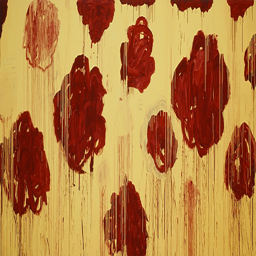

Generated caption: the red looks like blood are blood 
Generated LC: the red and black contrast well with the black background 
Generated IdC: the red looks like blood are blood 
Ground-truth captions: ['the dark red looks like dried blood', 'the red smears look like <unk> of blood', 'this looks like red clouds in the sky which is something to see so wing', 'because the dripping red ( possibly ) flowers look like blood spatter patters that were running down the wall'] 



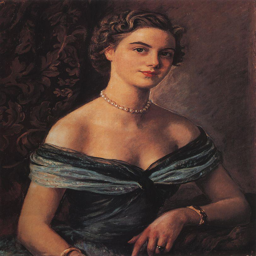

Generated caption: the woman looks like she is confident since she sees 
Generated LC: the woman is wearing a very fancy dress and a fancy headband 
Generated IdC: the woman looks like she is confident since she sees 
Ground-truth captions: ['the texture and facial expression make her look like a porcelain doll', 'a portrait of a woman that seems to be mildly attractive with lots of detail', 'lovely portrait of a young woman with good postures who does not look as though she posing against her will and has an actual smile', 'this is a stunning painting of a young woman in an elegant dress string of pearls complementing accessories and well <unk> hair that reminds me of a <unk> who is classy but <unk>', 'the lady looks like she is ready to go to a party and she is thinking that she looks pretty good all dressed up', 'the woman looks like she is happy and calm'] 



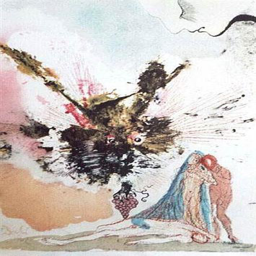

Generated caption: the red looks like blood and the man 
Generated LC: the colors are very dark and the woman looks scary 
Generated IdC: the red looks like blood and the man 
Ground-truth captions: ['there seems to be an explosion of a bird with black paint which looks disgusting', 'i am not sure what is going on here the people almost look sad but it looks like something exploded above them too', 'the blob in the center of the painting looks like it has open eyes it is really disturbing', 'it looks like there is a pair of eyes watching this couple from behind a mask of darkness', 'i am a bit unsure of what is happening but an individual appears to have been seriously hurt at the bottom it feels like a deity has been angered or <unk>'] 



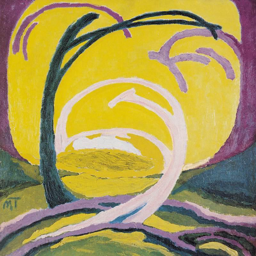

Generated caption: the colors are very bright and the yellow is very calming 
Generated LC: the colors are very bright and the yellow is very calming 
Generated IdC: the yellow looks like a yellow of the sun is like the sky 
Ground-truth captions: ['it looks like a large sun in the background', 'reminds me of a haunted forrest', 'the white lines are like wind flowing through a forest', 'for some reason this is a relaxing dreamy painting it looks like you are looking into a majestic wooded tunnel during sunset'] 



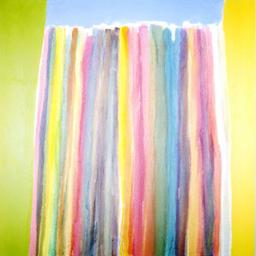

Generated caption: the colors remind me of a rainbow and 
Generated LC: the colors are very bright and the stripes are exciting 
Generated IdC: the colors remind me of a rainbow and 
Ground-truth captions: ['it looks like a bunch of different colored rubber bands on the wrist of someone', 'the stripes of color are like a rainbow waterfall', 'all the colors are so cheerful this almost makes me laugh out loud it is like a candy waterfall', 'pastel colors that look like a rainbow and remind me of easter'] 



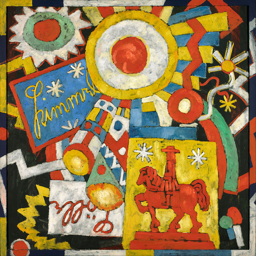

Generated caption: the colors are bright and the bright colors remind of a child 
Generated LC: the bright colors and shapes are exciting 
Generated IdC: the colors are bright and the bright colors remind of a child 
Ground-truth captions: ['the bright colors and patterns make it look like a party', 'reminds me of an advertisement for spain or mexico with the bright colors and geometric designs', 'the stars colors and overall clutter remind me of chinese new year', 'this looks like a pile of ads for a fair with ribbons for <unk> and elaborate candies between the signs the colors make you excited'] 



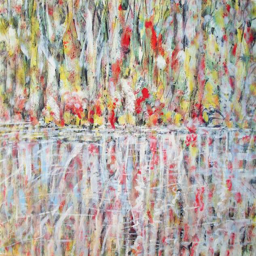

Generated caption: the colors are so bright and it looks like a mess 
Generated LC: the colors are very bright and the water is a bit creepy 
Generated IdC: the colors are so bright and it looks like a mess 
Ground-truth captions: ['i usually hate abstract art but this reminds me of colors shining off of water think it is pretty', 'this feels like an 8 am sunlit walk to work', 'the colors are beautiful the way the red pushes through it reminds me of a summers day', 'this is amazing it looks like a bunch of dancers in different colors dancing on ice where they are reflected'] 



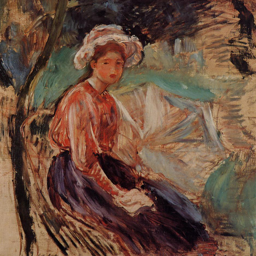

Generated caption: the woman 's face is very pretty and she looks very relaxed 
Generated LC: the woman 's face is very pretty and she looks very relaxed 
Generated IdC: the woman looks like she is wearing she has a lot of her dress 
Ground-truth captions: ['it looks like there is a black scary dog at the top', 'the subject looks like she is relaxing so i feel relaxed and happy too', 'the thick strokes make out to the middle where theres a beautiful woman it feels like confusion put into a picture', 'the busy brushstrokes look like <unk> winds', 'the facial expression of the subject looks very sad it does not look like she is enjoying her day', 'the color of the womans shirt reminds me of a fresh summer peach', 'this poor woman looks like she is incredibly sad about something i feel bad for her', 'the woman looks like she is having a pleasant time outside in the sun', 'this well dressed woman looks like a happy and affluent member of society', 'the woman looks as if she is being forced

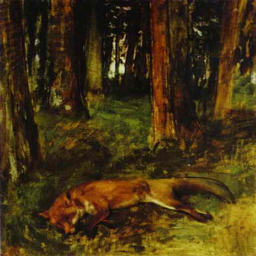

Generated caption: the dog looks like he is about to attack 
Generated LC: the deer looks so peaceful and the colors are dark 
Generated IdC: the dog looks like he is about to attack 
Ground-truth captions: ['the dark colors plus the red make it seems as though the fox has been shot a sad scene indeed', 'the fox is hurt and looks like it is experiencing a lot of pain', 'i like all the different shades of green incorporated into this painting the fox made me smile as he looks like he is hunting something', 'the fox appears dead or wounded he seems to be an omen or a warning that the forest behind him holds danger'] 



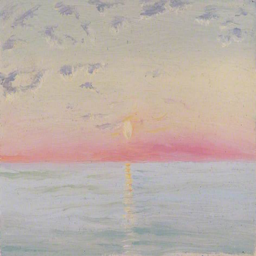

Generated caption: the colors are so bright and it looks like a beautiful 
Generated LC: the sun is setting and the sunset is a nice contrast to the water 
Generated IdC: the colors are so bright and it looks like a beautiful 
Ground-truth captions: ['it is a little <unk> for me to see a picture of the sunset across the ocean or lake as if i were there on the beach watching the sun go down', 'this is so beautiful it kind of reminds me of cotton candy since it is pink and blue', 'it looks like a calm serene day on the water at sunset a nice place to be', 'feels like watching a sunset with a loved one', 'this reminds me of cotton candy soothing the insides'] 



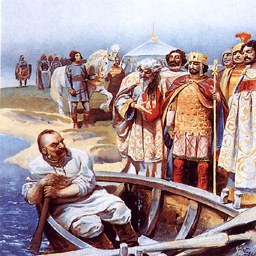

Generated caption: the man looks like he is about to the boat 
Generated LC: the man is wearing a crown of white 
Generated IdC: the man looks like he is about to the boat 
Ground-truth captions: ['the people have very stern looks on their faces and the man in the boat feels like he is being banished', 'the man in the boat has a defiant expression even though he is outnumbered by what appear to be a <unk> of royalty and soldiers i do not know the story but it is like a good movie i want to know what happens next', 'the man leaning towards the water as if falling in is a <unk> risk than the authoritative looking figures on shore', 'the men pictured seem to be in the midst of some sort of troublesome <unk> <unk>'] 



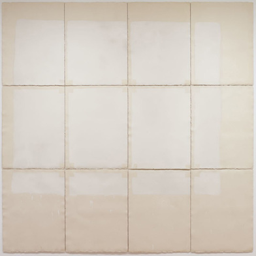

Generated caption: this looks like a very blank of a wall 
Generated LC: the painting is very plain and the colors are very neutral 
Generated IdC: this looks like a very blank of a wall 
Ground-truth captions: ['this looks like the tile in my old bathroom i think i am suppose to feel something and i just feel nothing and stupid', 'this reminds me of the tile in a prison shower', 'this tile floor reminds me of all the cleaning i need to do for my bathroom floor', 'the lines in the shapes make it look like they are giant blocks', 'that looks like the bathroom shower <unk> a dingy bathe', 'this looks like dirty tiles from a bathroom', 'nice photograph of white tile this makes me think of the tile <unk> in my bathroom white and nondescript rather boring', 'this reminds me of tile that i put in my bathroom', 'it reminds me of my bathroom floor when i move a rug', 'this image looks like a window is being reflected in ceramic tiles', 'it looks like a picture of a dirty tile floor', 'the colo

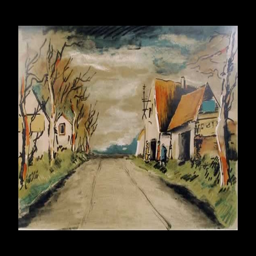

Generated caption: the dark colors make it look like a peaceful place 
Generated LC: the dark colors and lack of color makes me feel sad 
Generated IdC: the dark colors make it look like a peaceful place 
Ground-truth captions: ['it looks like a storm is coming and they scare me', 'it reminds me of a sad town where everyone is lonely the dark sky is ominous looking', 'it looks like a poor place', 'i feel like this image is stark and unsettling with the wispy leafless trees', 'this is an excellent painting of a moment in time the sky is troubled and the trees are bare almost makes me think of a tornado having just come through the buildings are simple and nothing grand could be a dirt street anywhere', 'this seems like a small town that would be nice to live in where everyone knows everyone and helps out', 'this painting of a rural roadway with small houses on either side on an autumn evening makes me excited as it reminds me of the places i used to visit as a child with my parents', 't

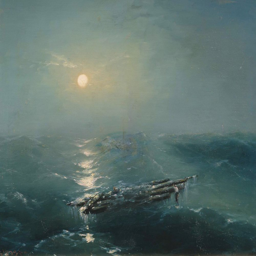

Generated caption: the waves look like they are sailing 
Generated LC: the sun is shining on the ocean 
Generated IdC: the waves look like they are sailing 
Ground-truth captions: ['the colors and the scene in this painting make me sad also it looks like the remnants of a shipwreck which makes me sad for the people that were on the ship', 'the objects in the ocean look like the remnants of a shipwreck', 'it looks as if the sea swallowed a boat during a storm', 'the <unk> in the middle of the sea seem to be a symbol of sunken ships'] 



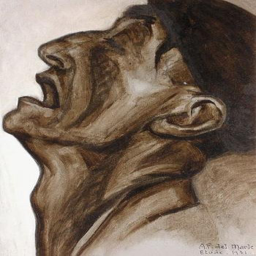

Generated caption: the man looks like he is about to chop since his 
Generated LC: the man looks very sad and the colors are dark 
Generated IdC: the man looks like he is about to chop since his 
Ground-truth captions: ["the man 's facial expressions appear as if he is tormented by something", 'the figure seems to be in great pain either physical or emotional', 'the man seems to be an elderly gentleman and he seems in pain', 'the man looks like he could be in pain i love the different mixes of browns and blacks the shades of brown on his face really contrast well with the hair on his head'] 



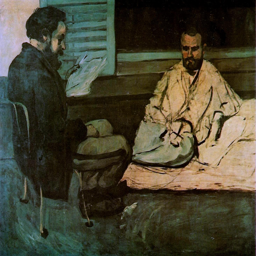

Generated caption: the man looks like he is about to die since his 
Generated LC: the man is sitting on the bed with his head 
Generated IdC: the man looks like he is about to die since his 
Ground-truth captions: ['there is something unsettling and almost unkind here my first impression was the figure in white was sick at any rate i feel like it is too friends but there appears nothing friendly dark brooding and nothing warm yet still familiar', 'these guys look like they got very bad news in the mail the guy wrapped in white is strange where are his arms and legs', 'the man in white looks like he is in a straight jacket and his companion is reading him news from the outside world it looks really interesting', 'they look like one is reading to the other person', 'the muted colors give off a gloomy feeling the man on the left looks like he is seeing the man on the left reluctantly giving the scene a sad feeling'] 



In [10]:
print("Evaluating on ArtEmis Id-captions ...")
img_dir = '../Dataset/ArtEmis/OriginalArtEmis/wikiart/'
for random_id in [28,321,21,1031,208,1038,612,685,1,1101,1201,1301,2001,1450,1750,2250,810,2303]:
    row = merged.iloc[random_id]
    img_file = osp.join(img_dir, row['art_style'], row['painting'] + '.jpg')
    image = Image.open(img_file).resize((256, 256))
    display(image)
    print("Generated caption:",row['captions_predicted'],
          "\nGenerated LC:",row['LC_predicted'],
          "\nGenerated IdC:",row['IdC_predicted'],
          "\nGround-truth captions:",row['references'],"\n") 

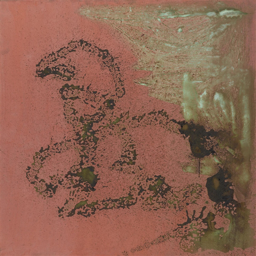

Generated caption: the black looks like blood and the ground 
Generated LC: the colors are very dark and the shapes are not very appealing 
Generated IdC: the black looks like blood and the ground 
Ground-truth captions: ['the colors are depressing and the shapes on the right side look like slime in a scary movie', 'looks like somebody pooped on this painting', 'the shapes resemble some sort of bacteria i could observe under a microscope', 'i feel like this is abstract'] 



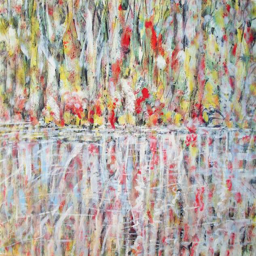

Generated caption: the colors are so bright and it looks like a mess 
Generated LC: the colors are very bright and the water is a bit creepy 
Generated IdC: the colors are so bright and it looks like a mess 
Ground-truth captions: ['i usually hate abstract art but this reminds me of colors shining off of water think it is pretty', 'this feels like an 8 am sunlit walk to work', 'the colors are beautiful the way the red pushes through it reminds me of a summers day', 'this is amazing it looks like a bunch of dancers in different colors dancing on ice where they are reflected'] 



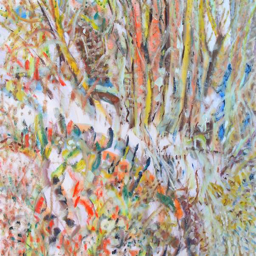

Generated caption: the colors look like a spider is very aggressively 
Generated LC: the colors are very bright and the lines are confusing 
Generated IdC: the colors look like a spider is very aggressively 
Ground-truth captions: ['the colors look fun together as if i am looking at exotic fish', 'the use of many colors with this painting makes me feel like having fun', 'some of the colorful lines look like they are fish swimming in the water', 'the colors and shapes look like a beautiful lion fish swimming near a coral reef', 'this abstract painting looks like a bowl of <unk> loops', 'it would be difficult to think of a color that is not represented here so many colors of different shapes and sizes intriguing', 'the colors mostly clash and it reminds me of vegetables that have gone bad and moldy', 'the bright almost explosive splashes of color make me think of fireworks and dreams', 'the orange yellow and gold colors remind me of fall and fall is my favorite time of year', 'the bright

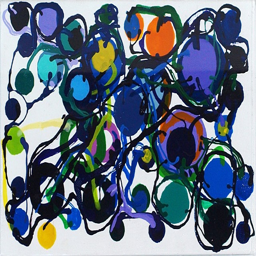

Generated caption: the colors are so many and the blue colors looks like a child 
Generated LC: the colors are very bright and the shapes are chaotic 
Generated IdC: the colors are so many and the blue colors looks like a child 
Ground-truth captions: ['these little circle things are so cool they kind of remind me of christmas lights since they are so brightly colored', 'these colorful balls remind me of my favorite hobby knitting because they look like balls of yarn', 'the busy nature of this painting reminds me of disorganization clutter and chaos', 'the squiggles have a lot of movement reminds me of happy little bugs crawling around', 'it looks like a <unk> map of <unk> going from table to table in a room filled with activities', 'the clash of purple orange and yellow is just very ugly to me it looks like a candy that would digest terribly in my stomach', 'the blue circles feel like bottomless holes and the black lines feel like paths going from bottomless hole to bottomless hole', 

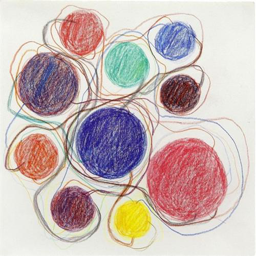

Generated caption: the colors look like they are dancing 
Generated LC: the colors are bright and plentiful 
Generated IdC: the colors look like they are dancing 
Ground-truth captions: ['it looks like something a child could draw', 'the random lines ringing varying sized balls of color seems to be a failed attempt at making a still life of colored balls of yarn', 'this painting is amusing because it was obviously drawn by a kid the circles and other lines are very basic and there is not much detail in the picture it looks like scribbles and a kid just having fun', 'circles look like brightly colored balloons'] 



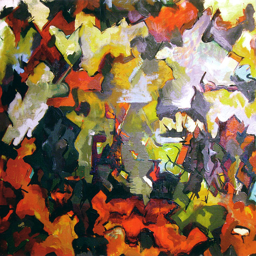

Generated caption: the colors are so bright and it looks like a mess 
Generated LC: the colors are very dark and the shapes are chaotic 
Generated IdC: the colors are so bright and it looks like a mess 
Ground-truth captions: ['this painting is very warm and it almost looks like a puzzle it looks like chaos but really it is all connected', 'looks like a paint spill in kindergarten do i have to clean this up too', 'the color in this picture are simply amazing about every color you can think of is in this picture', 'this reminds me of autumn leaves that have fallen from a tree', 'the shapes and colors seem like this could be in a video game', 'the red is very bold and makes me think of industry and accomplishing things', 'looks like puzzle pieces from many different puzzles', 'it looks like a knight is getting attacked by a big dragon', 'this feels like peering into a schizophrenic mind where nothing is real', 'the red color seems to be dominant in the chaos of colors', 'the painting loo

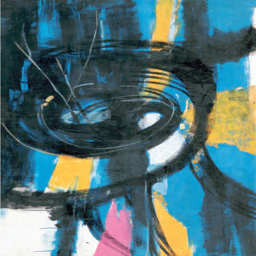

Generated caption: the black and white look like a dark of a child 
Generated LC: the colors are very dark and the black lines are exciting 
Generated IdC: the black and white look like a dark of a child 
Ground-truth captions: ['the dark swirl looks like something ominous is about to happen like a tornado or a hurricane', 'it looks like an exciting amusement park ride or something', 'staring at this painting actually makes me feel more than just sadness it makes me feel depressed it is the colors used the black swirls and circles going round and round overriding the bright colors putting them in the background instead the darkness looks like it is winning and can swallow you whole this abstract art reminds me of a tornado', 'this painting makes me happy and giggle when i look at the center of the painting it looks like a smile emo happy carefree joyful i see a goofy silly smiley face', 'the mix of the color blue and the black slowly enveloping the other brighter colors reminds me a bi

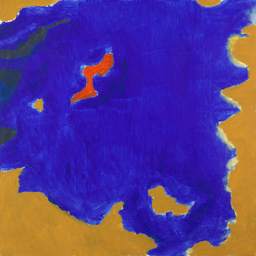

Generated caption: the blue color of the colors looks like a sunset 
Generated LC: the blue is a good contrast to the dark blue and black 
Generated IdC: the blue color of the colors looks like a sunset 
Ground-truth captions: ['this reminds me of a map the blue looks like the ocean and it makes me want to travel', 'painting looks like an ocean which brings me peace', 'reminds me of a large tranquil body of warm water', 'makes me think of the ocean and the <unk>'] 



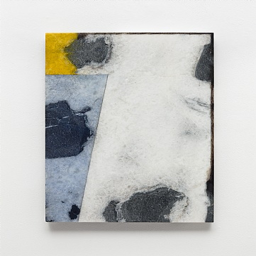

Generated caption: the colors are so simple and it looks like a map of a person is a mess 
Generated LC: the colors are very calming and the shapes are not very appealing 
Generated IdC: the colors are so simple and it looks like a map of a person is a mess 
Ground-truth captions: ['the muted colors on this make it look like a big piece of stone and therefore kind of stoic and peaceful', 'this looks like the tile on the floor of a very fancy house', 'the yellow in the painting reminds me of being a light when there is nothing but darkness very well done', 'the white and blue with the straight line feel unfriendly as if in a city and the yellow is a perceived threat'] 



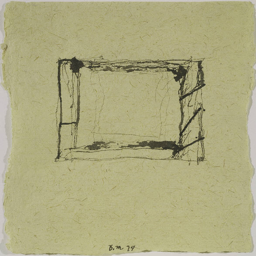

Generated caption: the black lines looks like a prison cell 
Generated LC: the painting is very simple and the colors are very basic 
Generated IdC: the black lines looks like a prison cell 
Ground-truth captions: ['this feels like a one way hole to nowhere good it has negative connotations', 'this picture resembles boredom i feel that whoever painted this was bored it makes me feel bored but i feel like so much could come out of this picture as well', 'this painting reminds me of a nice view looking out from a farmhouse window and it makes me feel calm', 'the square seems like it was drawn by a depressed person', 'this leaves me feeling empty and sad there is no color and the window seems to be distressed not in pristine condition makes me feel poor', 'it seems like a garden trellis'] 



In [11]:
img_dir = '../Dataset/ArtEmis/OriginalArtEmis/wikiart/'
#for random_id in [321,21,612,685]:
#    row = merged_IdC.iloc[random_id]
for _,row in merged_IdC[:10].iterrows():
    img_file = osp.join(img_dir, row['art_style'], row['painting'] + '.jpg')
    image = Image.open(img_file).resize((256, 256))
    display(image)
    print("Generated caption:",row['captions_predicted'],
          "\nGenerated LC:",row['LC_predicted'],
          "\nGenerated IdC:",row['IdC_predicted'],
          "\nGround-truth captions:",row['references'],"\n")  